In [1]:
# Import packages
import numpy as np
import os
import mahotas as mh
import cv2
import pylab


In [2]:
from Functions import create_dirs, check_sky, mask_seg, count_animals, smooth_animals, plot_image, get_centers_through_borders, get_bboxes, write_file, remove_bad_images, get_animal_dicts

In [3]:
# Set parameters
sigma = 2
minimum_animal_size = 10
kernel = (5,5)
date = "2019-11"
width = 512
height= 512


# Set locations
input_location = "../Data/images/" + date + "/"
input_location_s = "../Data/semantic/" + date + "/"
output_location = "../Data/labels/" + date + "/"
img_dir = os.listdir(input_location)
seg_dir = os.listdir(input_location_s)


# Set empty lists/dicts
bad_image_list = []
Detectron2_bbox_dict = {}


# Create the data directories
create_dirs(date)



Creation of the directory ../Data/images/2019-11 failed
Creation of the directory ../Data/labels/2019-11 failed
Creation of the directory ../Data/images/2019-11 failed


###----------###
IMG289_115,10.png
###----------###

This image contains 6 animals, including tiny blobs
This image contains 3 animals, excluding tiny blobs
Labeled blobs before erosion


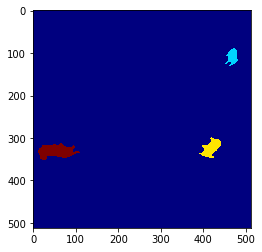

Labeled blobs after dilation


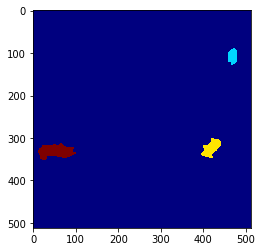

Real image


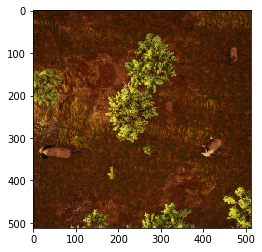

center locations: [(0.9143400493421052, 0.21415501644736842), (0.8152545797413793, 0.6327384159482758), (0.1095614346590909, 0.6482244318181818)] 

bboxes: [(0.044921875, 0.076171875), (0.091796875, 0.09375), (0.17578125, 0.076171875)] 

Proper animals found: writing file 

###----------###
IMG790_85,70.png
###----------###

This image contains 3 animals, including tiny blobs
This image contains 3 animals, excluding tiny blobs
Labeled blobs before erosion


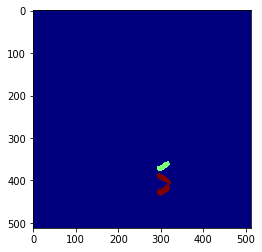

Labeled blobs after dilation


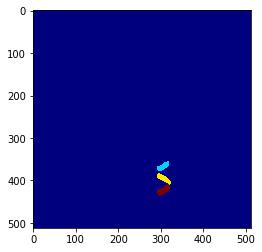

Real image


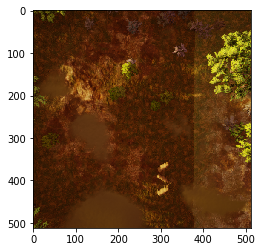

center locations: [(0.5971019847972973, 0.7151868665540541), (0.5999307753164557, 0.7740926621835443), (0.5981987847222222, 0.8239896797839507)] 

bboxes: [(0.0546875, 0.046875), (0.0625, 0.052734375), (0.056640625, 0.0546875)] 

Proper animals found: writing file 



In [5]:
# Run over semantic files and create ground truth 

with open("../Data/labels/00_SPLIT.txt","w") as file: 
    for image_name in os.listdir("../Data/semantic/" + date + "/test"): # + "/test"

        if image_name == "/test":
            continue
        # Input image from directory
        print("###----------###" + "\n" + image_name + "\n" + "###----------###" + "\n")
        input_image_s = input_location_s + image_name
        
        
        # If image contains sky, i.e. it's under the ground level, continue, else, write the file to the 00_SPLIT file
        if check_sky(input_image_s) == True:
            print("Warning, image contains sky. Removing from set.")
            bad_image_list.append(image_name)
            continue
        else:
            file.write(date + "/" + image_name + ' ' + "1") # The 1 refers to whether this is for training, test, or dev
            file.write("\n")
        
        
        # Mask everything but animals in image
        animals, mask = mask_seg(input_image_s)

        
        # Smooth animals with gaussian and remove tiny animals less than set size
        animals_smooth = smooth_animals(animals, sigma = sigma)

        
        # Count animals, if no animals are present, skip image
        labeled_animals, nr_objects = count_animals(animals_smooth, minimal_size = minimum_animal_size,image_kernel=kernel,save= True)
        if nr_objects == 0:
            print("Zero animals in this picture, not adding file information to labels file", "\n")
            continue
        else:
            plot_image(input_location + image_name)
        
        # Get centers of animals using boundaries
        centers_list = get_centers_through_borders(labeled_animals, nr_objects, width = width, height = height)
        
        
        # Get bboxes of animals in image
        #centers_list = get_centers(animals_smooth,clean_distance = clean_distance) # old
        bbox_list, bbox_dict_list = get_bboxes(labeled_animals, width = width, height = height)

        
        # Output centers and bboxes
        write_file(output_location,image_name,centers_list,bbox_list)
        
        # Make dict of bboxes for Detectron2
        if bbox_dict_list != None:
            Detectron2_bbox_dict[image_name] = bbox_dict_list
        # 242 289 355 789 790

In [ ]:
# Deletes images that have innapropriate compositions in them

remove_bad_images(bad_image_list)


In [ ]:
get_animal_dicts("../Data/images/2019-11/","../Data/semantic/2019-11/", Detectron2_bbox_dict)

In [ ]:

#from detectron2.data import DatasetCatalog
#DatasetCatalog.register("my_dataset", get_dicts)